# Movie Review Classifer

The purpose of this project is to build a model using Naive Bayes Theorem to classify whether a movie review is positive or negative. We will build our own dataset using IMDB and Rottentomatoes, separate it into two parts: a training set and a testing set.

First, let's import the necessary libraries.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from bs4 import BeautifulSoup
import unicodedata
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

## Collecting Movie Titles

We'll first collect a list of movie titles to use in our movie reviews gathering process. IMDB has a useful search feature that we can use. We've set the country to `'us'` for "United States", langauge to `'en'` for "English", start date to `'2008-01-01'` for "Jan 1, 2008", and end date to `2017-12-31'` for "Dec 31, 2017."

Each page shows 250 results, so we'll build a `for` loop that iterates through 6 pages, resulting in 1,500 titles/years in a list called `films` sorted by popularity based on IMDB. This should hopefully contain enough reviews to build a solid model for classifying future movie reviews.

In [50]:
country = 'us'
language = 'en'
start_date = '2008-01-01'
end_date = '2017-12-31'

count = 1
films = []

for i in range(6):
    url = f'https://www.imdb.com/search/title/?title_type=feature&release_date={start_date},{end_date}&countries={country}&languages={language}&view=simple&count=250&start={count}&ref_=adv_nxt'
    response = requests.get(url)
    soup = BeautifulSoup(response.content)
    titles = soup.find_all('span', class_ = 'lister-item-header')
    for n in range(250):
        films.append(titles[n].get_text())
    count += 250

Let's convert our list of titles into a dataframe that will be easier to manipulate going forward. We'll name the columns `film_title` and `dirty_year` for now.

In [51]:
data = pd.DataFrame(films)
data = pd.DataFrame(data[0].str.split('\n').to_list())
data.drop([0,1,2,5,6], inplace=True, axis=1)
data.columns = ['film_title', 'dirty_year']
data.tail()

,film_title,dirty_year
1495,Behaving Badly,(2014)
1496,To Rome with Love,(2012)
1497,Europa Report,(2013)
1498,Creep 2,(2017)
1499,Project Almanac,(2015)


We'll need to clean the `dirty_year` column, removing the parentheses and any extra information. Let's build a simple function called `clean_year` that returns the 4-digit year.

We'll use the `apply()` method to apply the function to the entire column, rename it `year`, convert it to an integer, and then drop the `dirty_year` column.

In [52]:
def clean_year(string):
    return string[-5:-1]

data['clean_year'] = data['dirty_year'].apply(clean_year).astype(int)
data.drop('dirty_year', inplace=True, axis=1)
data.tail()

,film_title,clean_year
1495,Behaving Badly,2014
1496,To Rome with Love,2012
1497,Europa Report,2013
1498,Creep 2,2017
1499,Project Almanac,2015


2017    0.134000
2016    0.120667
2014    0.109333
2013    0.104000
2015    0.103333
2011    0.091333
2012    0.088667
2010    0.085333
2009    0.084667
2008    0.078667
Name: clean_year, dtype: float64

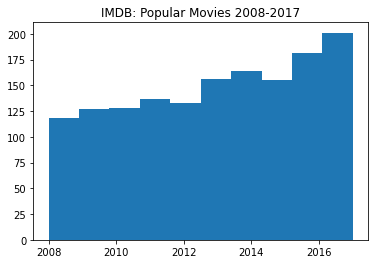

In [53]:
plt.hist(data['clean_year'])
plt.title('IMDB: Popular Movies 2008-2017')
data['clean_year'].value_counts(normalize=True)

## Collecting Movie Reviews

So, now that we have our list of most popular 1,500 titles/years from 2008-2017, we can begin writing functions to collect movie reviews from Rotten Tomatoes.

We'll build functions to format our movie title, find the appropriate Rotten Tomatoes url associated with that title, retrieve the soup, retrieve and sort the reviews, and build a new dataframe containing all of that information.

### Clean Film Title

This function takes a film title as a string, replaces spaces with underscores, makes the string lowercase, removes special characters, and converts accented characters to regular ones.

In [160]:
def clean_film_title(title):
    title = title.lower().replace(" ", "_")
    special_chars = ",)(:.'!/-?"
    for special_char in special_chars:
        title = title.replace(special_char, "")
    try:
        title = unicode(title, 'utf-8')
    except NameError:
        pass
    title = unicodedata.normalize('NFD', title)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    title = title.replace("&", "and")
    title = title.replace('__', '_')

    return title

test_title = data['film_title'][0]
print(f"Title: {test_title}")
print(f"Clean Title: {clean_film_title(test_title)}")

Title: Interstellar
Clean Title: interstellar


### Find URL

This function takes a cleaned film title and year and attempts to find the correct Rotten Tomatoes URL for that film. There are essentially three useful URL patterns RT uses on their website:
1. Film with the year tacked on the end.
2. Film without the year.
3. Film without an article (like 'the' or 'a') at the beginning.

There are special cases where the correct URL cannot be found using the method above. For example the URL for Braveheart is https://www.rottentomatoes.com/m/1065684-braveheart. I haven't been able to decipher the what the 7 digits preceding the film title mean.

In [210]:
def find_url(title, year):
    url = f'https://www.rottentomatoes.com/m/{title}_{year}'
    response = requests.get(url)
    
    if response.status_code != 200:
        url = f'https://www.rottentomatoes.com/m/{title}'
        response = requests.get(url)
        
    if response.status_code != 200:
        title = re.sub("^\w{0,3}_", "", title)
        url = f'https://www.rottentomatoes.com/m/{title}'
        response = requests.get(url)
    
    soup = BeautifulSoup(response.content, 'html.parser')
    rt_year = soup.find('p', class_ = 'scoreboard__info')
    try:
        rt_year = rt_year.get_text().split(',')
        rt_year = rt_year[0]
    except (AttributeError, IndexError, ValueError):
        rt_year = 0
    return url, rt_year

test_title = clean_film_title(data['film_title'][0])
test_year = data['clean_year'][0]
print(find_url(test_title, test_year))

('https://www.rottentomatoes.com/m/interstellar_2014', '2014')


### Find Reviews

This function takes a piece of a URL containing a film title and returns all the critic reviews for that film organizing them into either 'fresh' or 'rotten.'

In [237]:
def find_reviews(url):
    fresh_reviews = []
    rotten_reviews = []
    review_type = ['fresh', 'rotten']
    for t in review_type:
        url2 = f'{url}/reviews?type=&sort={t}&page=1'
        response = requests.get(url2)
        soup = BeautifulSoup(response.content, 'html.parser')
        pages = 0
        try: 
            pages = int(soup.find_all('span', class_ = 'pageInfo')[0].get_text()[-2:])
        except IndexError:
            pass
        if pages == 0:
            pages += 2
        else:
            pages += 1
        for page in range(1, pages):
            url2 = f'{url}/reviews?type=&sort={t}&page={page}'
            response = requests.get(url2)
            soup = BeautifulSoup(response.content, 'html.parser')
            content = soup.find_all('div', class_ = 'the_review')
            for i in range(len(content)):
                if t == 'fresh':
                    fresh_reviews.append(content[i].get_text())
                if t == 'rotten':
                    rotten_reviews.append(content[i].get_text())
    print(f'Fresh:{len(fresh_reviews)} Rotten:{len(rotten_reviews)}')
    print('\n')
    return fresh_reviews, rotten_reviews
                        
fresh, rotten = find_reviews('https://www.rottentomatoes.com/m/interstellar_2014')

Fresh:264 Rotten:102




### Rotten Tomatoes and Apply & Concat

These two functions combine the above functions and gives us an easy way to apply our functions to an existing pandas series to build our new dataframe.

In [238]:
def rotten_tomatoes(title, dataframe):
    year = dataframe.loc[dataframe['film_title'] == title]['clean_year'].values[0]
    print(f"{dataframe[dataframe['film_title'] == title].index.values}, {title}, {year}")
    title = clean_film_title(title)
    url, rt_year = find_url(title, year)
    print(url)
    if abs(int(rt_year) - int(year) < 2):
           return find_reviews(url)
    else:
           return np.nan

def apply_and_concat(dataframe, field, function, column_names):
           return pd.concat((dataframe, dataframe[field].apply
                            (lambda cell: pd.Series(function(cell, dataframe),
                                                   index=column_names))), axis=1)

In [239]:
reviews = apply_and_concat(data, 'film_title', rotten_tomatoes, ['fresh_reviews', 'rotten_reviews'])

[0], Interstellar, 2014
https://www.rottentomatoes.com/m/interstellar_2014
Fresh:264 Rotten:102


[1], The Dark Knight, 2008
https://www.rottentomatoes.com/m/the_dark_knight_2008
Fresh:323 Rotten:21


[2], Fifty Shades of Grey, 2015
https://www.rottentomatoes.com/m/fifty_shades_of_grey
Fresh:69 Rotten:212


[3], Thor: Ragnarok, 2017
https://www.rottentomatoes.com/m/thor_ragnarok_2017
Fresh:402 Rotten:30


[4], State of Play, 2009
https://www.rottentomatoes.com/m/state_of_play
Fresh:0 Rotten:0


[5], The Wolf of Wall Street, 2013
https://www.rottentomatoes.com/m/the_wolf_of_wall_street_2013
Fresh:227 Rotten:59


[6], G.I. Joe: The Rise of Cobra, 2009
https://www.rottentomatoes.com/m/gi_joe_the_rise_of_cobra
Fresh:57 Rotten:113


[7], Inception, 2010
https://www.rottentomatoes.com/m/inception
Fresh:313 Rotten:47


[8], R.I.P.D., 2013
https://www.rottentomatoes.com/m/ripd
Fresh:13 Rotten:91


[9], Inglourious Basterds, 2009
https://www.rottentomatoes.com/m/inglourious_basterds
Fresh:294 R

## Build our Naive Bayes' Classifier

Now, that we've collected all of our movie reviews for the top 1,500 movies from 2008-2017, let's see how many reviews we actually have to work with.

In [255]:
reviews['n_fresh_reviews'] = reviews['fresh_reviews'].apply(lambda x: len(x) if type(x) is list else np.nan)
reviews['n_rotten_reviews'] = reviews['rotten_reviews'].apply(lambda x: len(x) if type(x) is list else np.nan)
reviews.head()
print(f"Fresh Reviews: {round(reviews['n_fresh_reviews'].sum()):,}")
print(f"Rotten Reviews: {round(reviews['n_rotten_reviews'].sum()):,}")

Fresh Reviews: 146,607
Rotten Reviews: 86,920


As you can see, we have over 230k reviews from which to build a classifier. We'll need to clean each review, making all the words lower-case and removing the special characters. Although our fresh reviews vastly outnumber our rotten reviews, this shouldn't necessarily be a problem. 

In [386]:
def clean_reviews(reviews):
    clean_reviews = []
    try:
        for n in range(len(reviews)):
            clean_review = []
            review = reviews[n].split()
            for i in range(len(review)):
                word = review[i].lower()
                special_chars = ",)][\"(:;.'!/?"
                for special_char in special_chars:
                    word = word.replace(special_char, "")
                clean_review.append(word)
            clean_reviews.append(clean_review)
        return clean_reviews
    except TypeError:
        empty_list = []
        return empty_list

fresh_reviews = list(reviews['fresh_reviews'].apply(clean_reviews))
rotten_reviews = list(reviews['rotten_reviews'].apply(clean_reviews))   

In [387]:
import itertools
flat_fresh_reviews = list(itertools.chain(*fresh_reviews))
flat_rotten_reviews = list(itertools.chain(*rotten_reviews))

In [388]:
print(len(flat_fresh_reviews))
print(len(flat_rotten_reviews))

146607
86920


In [407]:
fresh = pd.Series(flat_fresh_reviews)
fresh = pd.DataFrame(fresh, columns= ['review'])
fresh['label'] = 'fresh'

rotten = pd.Series(flat_rotten_reviews)
rotten = pd.DataFrame(rotten, columns= ['review'])
rotten['label'] = 'rotten'

all_reviews = pd.concat([fresh, rotten])
all_reviews.tail()

,review,label
86915,"[the, found-footage, technique, is, aimed, at,...",rotten
86916,"[, it, doesnt, quite, work, but, the, young, t...",rotten
86917,"[pretends, to, be, intelligent, long, enough, ...",rotten
86918,"[what, have, we, done, to, deserve, another, f...",rotten
86919,"[a, time-travel, premise, goes, nowhere, fast,...",rotten


In [408]:
def list_to_string(list1):
    string1 = " "
    return string1.join(list1)

all_reviews['review'] = all_reviews['review'].apply(list_to_string)
all_reviews.tail()

,review,label
86915,the found-footage technique is aimed at teens ...,rotten
86916,it doesnt quite work but the young teen audie...,rotten
86917,pretends to be intelligent long enough to get ...,rotten
86918,what have we done to deserve another found-foo...,rotten
86919,a time-travel premise goes nowhere fast in thi...,rotten


In [413]:
rand_reviews = all_reviews.sample(frac=1, random_state=1).copy()
first_80 = round(rand_reviews.shape[0] * .8)

training_set = rand_reviews[:first_80].copy()
training_set.reset_index(drop=True, inplace=True)
testing_set = rand_reviews[first_80:].copy()
testing_set.reset_index(drop=True, inplace=True)

print('Training Set:')
print(training_set['label'].value_counts(normalize=True))
print('\n')
print('Testing Set:')
print(testing_set['label'].value_counts(normalize=True))

Training Set:
fresh     0.627779
rotten    0.372221
Name: label, dtype: float64


Testing Set:
fresh     0.627856
rotten    0.372144
Name: label, dtype: float64


In [459]:
vocab_dict = {}
def build_vocab(review):
    review = review.split()
    for word in review:
        if word in vocab_dict:
            vocab_dict[word] += 1
        else:
            vocab_dict[word] = 1
            
training_set['review'].apply(build_vocab)
print(vocab_dict['the'])

222005


In [461]:
sorted_vocab = sorted(vocab_dict.items(), key = lambda x: x[1])
sorted_vocab = pd.DataFrame(sorted_vocab, columns = ['key', 'value'])
sorted_vocab = sorted_vocab[(sorted_vocab['value'] > 2) & (sorted_vocab['value'] < 6000)]
vocab = list(sorted_vocab['key'])
sorted_vocab.tail()

,key,value
89268,review,5869
89269,fun,5897
89270,way,5922
89271,movies,5936
89272,which,5953
